In [ ]:
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork
from TemporalStability import FlowIntegralClustering
import numpy as np
import time
import matplotlib.pyplot as plt

# Example of non-stationary temporal network (Fig. 1)


In [ ]:
inter_tau = 1
activ_tau = 1
t_start = 0
n_groups = 3
n_per_group = 9
individuals = []


m1=0.95
p1=0.95
deltat1 =120
deltat2=40

t_end = 3*deltat1+2*deltat2




def make_step_block_probs(deltat1, deltat2, m1=1, p1=1):
    """ Returns a function that generate the block probability matrix as a function of time.
    
        `deltat1` is the length of the within step
    
        `deltat2` is the length of the echanging step
        
        `m1` is the prob of self-interaction (during deltat1)
        
        `p1` is the prob of cross-interaction (during deltat2)
    """


    def block_mod_func(t):
        
        m2 = (1-m1)/2
        p2 = (1-p1)
        
        ex12 = np.array([[p2,p1,0],
                         [p1,p2,0],
                         [0,0,1]])
        ex23 = np.array([[1,0,0],
                         [0,p2,p1],
                         [0,p1,p2]])
        ex13 = np.array([[p2,0,p1],
                         [0, 1, 0],
                         [p1,0,p2]])
    
        I = np.array([[m1,m2,m2],
                      [m2,m1,m2],
                      [m2,m2,m1]])
        if t>=0 and  t < deltat1:
            return ex12
        elif t>=deltat1 and t<deltat1+deltat2:
            return I
        elif t>=deltat1+deltat2 and t < 2*deltat1+deltat2:
            return ex23
        elif t>= 2*deltat1+deltat2 and t < 2*(deltat1+deltat2):
            return I
        elif t>= 2*(deltat1+deltat2) and t < 2*(deltat1+deltat2)+deltat1:
            return ex13
        else:
            print('Warning : t must be >=0 and <= 3*deltat1+2*deltat2' +\
                  't is ', t)
            return I
        
    return block_mod_func
 


block_prob_mod_func = make_step_block_probs(deltat1,deltat2,m1,p1)


In [ ]:
# create agents for the simlation
for g in range(n_groups):

    individuals.extend([Individual(i, inter_distro_scale=inter_tau,
                                      activ_distro_scale=activ_tau,
                                      group=g) for i in range(g*n_per_group,(g+1)*n_per_group)])

In [ ]:
# run simulation
sim = SynthTempNetwork(individuals=individuals, t_start=t_start, t_end=t_end,
                       next_event_method='block_probs_mod',
                       block_prob_mod_func=block_prob_mod_func)

print('running simulation')
t0 = time.time()
sim.run(save_all_states=True, save_dt_states=True, verbose=False)
print(f'done in {time.time()-t0:.2f}s')


## Creating a continuous time temporal network

In [ ]:
# creating a temporal network from the simulation's result
net = ContTempNetwork(source_nodes=sim.indiv_sources,
                      target_nodes=sim.indiv_targets,
                      starting_times=sim.start_times,
                      ending_times=sim.end_times,
                      merge_overlapping_events=True)

In [ ]:
# the events of the temporal network are saved in a pandas dataframe in net.events_table
net.events_table

In [ ]:
# all the event times (starts and ends) are saved in 
net.times

In [ ]:
# Compute inter transition matrices. 
# lamda is random walk rate.
# By default, the matrix exponention is computed using the version for dense matrices, 
# which is faster but only works for small networks. 
# To use the sparse implementation, set `dense_expm=False`

lamda=1/10
t0 = time.time()
net.compute_inter_transition_matrices(lamda=lamda, verbose=True)
print(f'done in {time.time()-t0:.2f}s')

In [ ]:
# the matrices are saved in a list here
net.inter_T[lamda]
# where net.inter_T[lamda][k] is the probability transition matrix
# between net.times[k] and net.times[k+1]

In [ ]:
# the temporal network can be saved, togheter with the inter-event transition matrices in a pickle file:
net.save('example_network')


In [ ]:
# and can be loaded unsing `ContTempNetwork.load`
net2 = ContTempNetwork.load('example_network')


## Computing the covariance integral

In [ ]:
# We can now compute the integral of the covariance using FlowIntegralClustering.
# We need to give the inter-event transition matrices, the inter-event times and 
# a list of times until which to compute the integral is computed.

integral_time_grid = np.linspace(0, t_end, 12, endpoint=True)

I_forw = FlowIntegralClustering(T_inter_list=net.inter_T[lamda], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                verbose=True)

In [ ]:
# The list of transition matrices are stored in 
I_forw.T_list
# where I_forw.T_list[k] contains the transition matrix between net.times[0] and net.times[k+1]

In [ ]:
# The autocovariance integrals are stored in 
I_forw.I_list
# I_forw.I_list[k] contains the integral of the autocovariance 
# from I_forw._t_integral_grid[0] to I_forw._t_integral_grid[k+1]

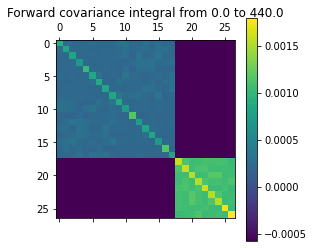

In [217]:
plt.matshow(I_forw.I_list[10].toarray())
plt.colorbar()
_ =  plt.title(f'Forward covariance integral from {I_forw.integral_time_grid[0]} to {I_forw.integral_time_grid[11]}')


In [ ]:
# similarly, we can compute the backward covariance integral, by reversing time.
I_back = FlowIntegralClustering(T_inter_list=net.inter_T[lamda], 
                                time_list=net.times,
                                integral_time_grid=integral_time_grid,
                                reverse_time=True,
                                verbose=True)

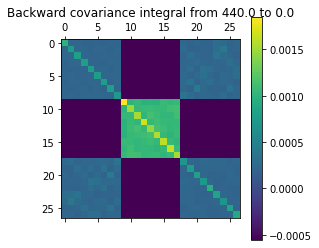

In [218]:
plt.matshow(I_back.I_list[10].toarray())
plt.colorbar()
_ = plt.title(f'Backward covariance integral from {I_back.integral_time_grid[0]} to {I_back.integral_time_grid[11]}')


## Optimizing the flow stability to find the best partition

In [ ]:
# we can now find the partition optimizing the flow stability, 
# i.e. best clustering the covariance integral, with the Louvain algorithm
I_forw.find_louvain_clustering(k=10)

In [ ]:
# the result is saved in 
I_forw.partition[10]
# and is a `Partition` object 

In [219]:
# the cluster list is stored in 
I_forw.partition[10].cluster_list

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17},
 {18, 19, 20, 21, 22, 23, 24, 25, 26}]

In [ ]:
# a dictionary mapping node ids to cluster ids is also availiable
I_forw.partition[10].node_to_cluster_dict

In [ ]:
# Similarly for the backward flow stability
I_back.find_louvain_clustering(k=10)


In [221]:
I_back.partition[10].cluster_list

[{9, 10, 11, 12, 13, 14, 15, 16, 17},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26}]